In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.layers import Dense

In [ ]:
dst = pd.read_excel("/content/dst25.xlsx")
fuds = pd.read_excel("/content/fuds25.xlsx")

In [ ]:
data = pd.concat([dst,fuds],axis = 0, ignore_index=True)
data

,Data_Point,Test_Time(s),Date_Time,Step_Time(s),Step_Index,Cycle_Index,Current(A),Voltage(V),Charge_Capacity(Ah),Discharge_Capacity(Ah),Charge_Energy(Wh),Discharge_Energy(Wh),dV/dt(V/s),Internal_Resistance(Ohm),Is_FC_Data,AC_Impedance(Ohm),ACI_Phase_Angle(Deg)
0,1,60.013121,2015-11-05 10:17:58,60.013122,1,1,0.000000,3.435067,0.000000,0.000000,0.000000,0.000000,0.000032,0,0,0,0
1,2,70.028598,2015-11-05 10:18:08,10.015045,2,1,0.999834,3.536407,0.002781,0.000000,0.009817,0.000000,0.001198,0,0,0,0
2,3,80.029043,2015-11-05 10:18:18,20.015490,2,1,1.000014,3.544340,0.005559,0.000000,0.019650,0.000000,0.000712,0,0,0,0
3,4,90.044033,2015-11-05 10:18:28,30.030479,2,1,0.999834,3.549358,0.008336,0.000000,0.029501,0.000000,0.000486,0,0,0,0
4,5,100.044538,2015-11-05 10:18:38,40.030985,2,1,0.999653,3.552596,0.011117,0.000000,0.039378,0.000000,0.000291,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18804,9304,31144.199015,2015-11-10 18:23:00,198.264234,7,1,-3.999431,2.689097,1.012736,2.231046,4.016000,7.998665,-0.038043,0,0,0,0
18805,9305,31145.214731,2015-11-10 18:23:01,199.279950,7,1,-3.017820,2.719856,1.012736,2.232100,4.016000,8.001478,-0.019750,0,0,0,0
18806,9306,31146.230372,2015-11-10 18:23:02,200.295592,7,1,-3.999431,2.602327,1.012736,2.233024,4.016000,8.003961,-0.032928,0,0,0,0
18807,9307,31147.246026,2015-11-10 18:23:03,201.311245,7,1,-3.832909,2.556189,1.012736,2.234139,4.016000,8.006831,-0.031794,0,0,0,0


In [ ]:
data['Temperature(degree_C)'] = 25
data.insert(0, 'Temperature(degree_C)', data.pop('Temperature(degree_C)'))
data["Discharge_Capacity - Charge_Capacity(Ah)"] = data["Discharge_Capacity(Ah)"] - data["Charge_Capacity(Ah)"]
data["Discharge_Energy - Charge_Energy(Wh)"] = data["Discharge_Energy(Wh)"] - data["Charge_Energy(Wh)"]
initial_soc = {1:90}
def calculate_soc(combine_data, initial_soc):
    combine_data["SOC"] = 0
    for cycle_index, group in combine_data.groupby("Cycle_Index"):
        soc = initial_soc[cycle_index]
        for i in range(len(group)):
            if group["Current(A)"].iloc[i] > 0:
                soc += group["Charge_Capacity(Ah)"].iloc[i]
            else:
                soc -= group["Discharge_Capacity(Ah)"].iloc[i]
            combine_data.loc[i, "SOC"] = soc
    return combine_data

data = calculate_soc(data.copy(), initial_soc.copy())
data = data.drop("Date_Time",axis = 1)
data

,Temperature(degree_C),Data_Point,Test_Time(s),Step_Time(s),Step_Index,Cycle_Index,Current(A),Voltage(V),Charge_Capacity(Ah),Discharge_Capacity(Ah),Charge_Energy(Wh),Discharge_Energy(Wh),dV/dt(V/s),Internal_Resistance(Ohm),Is_FC_Data,AC_Impedance(Ohm),ACI_Phase_Angle(Deg),Discharge_Capacity - Charge_Capacity(Ah),Discharge_Energy - Charge_Energy(Wh),SOC
0,25,1,60.013121,60.013122,1,1,0.000000,3.435067,0.000000,0.000000,0.000000,0.000000,0.000032,0,0,0,0,0.000000,0.000000,90.000000
1,25,2,70.028598,10.015045,2,1,0.999834,3.536407,0.002781,0.000000,0.009817,0.000000,0.001198,0,0,0,0,-0.002781,-0.009817,90.002781
2,25,3,80.029043,20.015490,2,1,1.000014,3.544340,0.005559,0.000000,0.019650,0.000000,0.000712,0,0,0,0,-0.005559,-0.019650,90.008340
3,25,4,90.044033,30.030479,2,1,0.999834,3.549358,0.008336,0.000000,0.029501,0.000000,0.000486,0,0,0,0,-0.008336,-0.029501,90.016676
4,25,5,100.044538,40.030985,2,1,0.999653,3.552596,0.011117,0.000000,0.039378,0.000000,0.000291,0,0,0,0,-0.011117,-0.039378,90.027793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18804,25,9304,31144.199015,198.264234,7,1,-3.999431,2.689097,1.012736,2.231046,4.016000,7.998665,-0.038043,0,0,0,0,1.218310,3.982665,-16401.419178
18805,25,9305,31145.214731,199.279950,7,1,-3.017820,2.719856,1.012736,2.232100,4.016000,8.001478,-0.019750,0,0,0,0,1.219364,3.985479,-16403.651278
18806,25,9306,31146.230372,200.295592,7,1,-3.999431,2.602327,1.012736,2.233024,4.016000,8.003961,-0.032928,0,0,0,0,1.220288,3.987961,-16405.884302
18807,25,9307,31147.246026,201.311245,7,1,-3.832909,2.556189,1.012736,2.234139,4.016000,8.006831,-0.031794,0,0,0,0,1.221403,3.990831,-16408.118441


In [ ]:
X = data.drop("SOC",axis = 1)
y = data["SOC"] / 100
# Define test size (ratio of data to be used for testing)
test_size = 0.2  # 20% for testing

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Print the shapes of training and testing sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
X_train.columns

X_train shape: (15047, 19)
X_test shape: (3762, 19)
y_train shape: (15047,)
y_test shape: (3762,)


Index(['Temperature(degree_C)', 'Data_Point', 'Test_Time(s)', 'Step_Time(s)',
       'Step_Index', 'Cycle_Index', 'Current(A)', 'Voltage(V)',
       'Charge_Capacity(Ah)', 'Discharge_Capacity(Ah)', 'Charge_Energy(Wh)',
       'Discharge_Energy(Wh)', 'dV/dt(V/s)', 'Internal_Resistance(Ohm)',
       'Is_FC_Data', 'AC_Impedance(Ohm)', 'ACI_Phase_Angle(Deg)',
       'Discharge_Capacity - Charge_Capacity(Ah)',
       'Discharge_Energy - Charge_Energy(Wh)'],
      dtype='object')

In [ ]:
model1 = LinearRegression()
model1.fit(X_train,y_train)
coefficients = model1.coef_
print("Coefficients: ",coefficients)

Coefficients:  [ 0.00000000e+00  3.55153861e-03 -1.96805027e-03  7.92476837e-04
  9.71764044e+00  2.97539771e-14  5.75066199e+00 -6.28991727e+01
  2.72185556e+02 -2.14166816e+02 -6.43993862e+01  5.47071754e+01
 -2.17497826e+01  6.31369036e-41  5.73971851e-42  1.09604723e-55
  0.00000000e+00 -4.86352372e+02  1.19106562e+02]


In [ ]:
model2 = RandomForestRegressor(n_estimators=100, random_state=42)
model2.fit(X_train,y_train)
# Get feature importances
feature_importances = model2.feature_importances_

# Print feature names and importances
feature_names = X.columns
for feature, importance in zip(feature_names, feature_importances):
    print(f"{feature}: {importance:.4f}")


Temperature(degree_C): 0.0000
Data_Point: 0.0151
Test_Time(s): 0.0141
Step_Time(s): 0.0019
Step_Index: 0.0003
Cycle_Index: 0.0000
Current(A): 0.0006
Voltage(V): 0.0394
Charge_Capacity(Ah): 0.0007
Discharge_Capacity(Ah): 0.0103
Charge_Energy(Wh): 0.0007
Discharge_Energy(Wh): 0.0100
dV/dt(V/s): 0.0004
Internal_Resistance(Ohm): 0.0000
Is_FC_Data: 0.0000
AC_Impedance(Ohm): 0.0000
ACI_Phase_Angle(Deg): 0.0000
Discharge_Capacity - Charge_Capacity(Ah): 0.8635
Discharge_Energy - Charge_Energy(Wh): 0.0429


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 5.5 MB/s eta 0:00:00


 97%|=================== | 3635/3762 [00:17<00:00]       

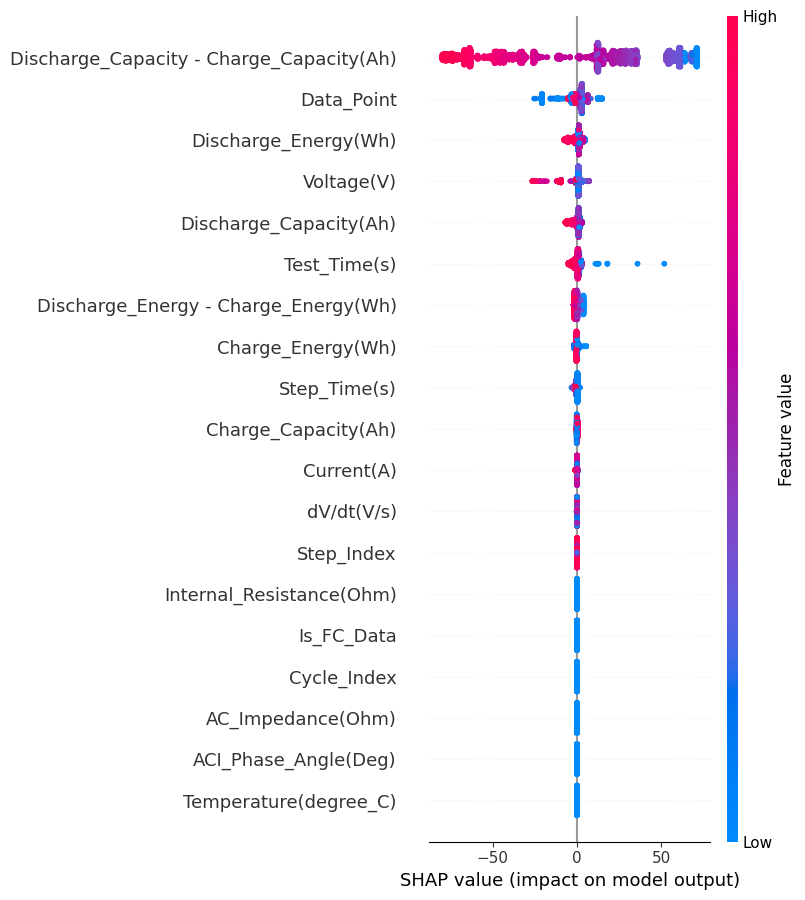

In [ ]:
!pip install shap
import shap
from shap import Explainer


# Train your machine learning model (replace with your model)
model3 = XGBRegressor(n_estimators=100, random_state=42)  # Example model
model3.fit(X_train, y_train)

# Instantiate SHAP explainer for your model and data
explainer = shap.Explainer(model3, X_train)  # Use training data for this example

# Calculate SHAP values for an individual instance or all instances
# Replace with your desired index or array for specific instance(s)

shap_values = explainer(X_test)  # Get SHAP values for all instances in X_test
# Example visual explanations
shap.summary_plot(shap_values, X_test)  # Summary plot for all features


In [ ]:
numeric_features = data.select_dtypes(include = [np.number])
corr_matrix = numeric_features.corr()
corr_matrix

,Temperature(degree_C),Data_Point,Test_Time(s),Step_Time(s),Step_Index,Cycle_Index,Current(A),Voltage(V),Charge_Capacity(Ah),Discharge_Capacity(Ah),Charge_Energy(Wh),Discharge_Energy(Wh),dV/dt(V/s),Internal_Resistance(Ohm),Is_FC_Data,AC_Impedance(Ohm),ACI_Phase_Angle(Deg),Discharge_Capacity - Charge_Capacity(Ah),Discharge_Energy - Charge_Energy(Wh),SOC
Temperature(degree_C),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Data_Point,NaN,1.000000,0.848871,-0.512978,0.726723,NaN,-0.239459,-0.792037,0.243483,0.947831,0.248988,0.938707,-0.013333,NaN,NaN,NaN,NaN,0.587157,0.564184,-0.485755
Test_Time(s),NaN,0.848871,1.000000,-0.512688,0.945287,NaN,-0.325589,-0.820463,0.410396,0.914666,0.420748,0.921428,-0.009177,NaN,NaN,NaN,NaN,0.439553,0.422825,-0.245050
Step_Time(s),NaN,-0.512978,-0.512688,1.000000,-0.558596,NaN,0.229019,0.542529,-0.148977,-0.544857,-0.152010,-0.547004,0.008044,NaN,NaN,NaN,NaN,-0.330999,-0.323622,0.192518
Step_Index,NaN,0.726723,0.945287,-0.558596,1.000000,NaN,-0.349249,-0.789999,0.194940,0.863143,0.208587,0.875178,-0.006875,NaN,NaN,NaN,NaN,0.554097,0.543493,-0.362883
Cycle_Index,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Current(A),NaN,-0.239459,-0.325589,0.229019,-0.349249,NaN,1.000000,0.481307,-0.098226,-0.269059,-0.105220,-0.273353,0.479951,NaN,NaN,NaN,NaN,-0.145593,-0.139994,0.113344
Voltage(V),NaN,-0.792037,-0.820463,0.542529,-0.789999,NaN,0.481307,1.000000,-0.098308,-0.894844,-0.101311,-0.899355,0.143901,NaN,NaN,NaN,NaN,-0.649621,-0.642462,0.401079
Charge_Capacity(Ah),NaN,0.243483,0.410396,-0.148977,0.194940,NaN,-0.098226,-0.098308,1.000000,0.148634,0.999740,0.151144,-0.003005,NaN,NaN,NaN,NaN,-0.604534,-0.621909,0.696072
Discharge_Capacity(Ah),NaN,0.947831,0.914666,-0.544857,0.863143,NaN,-0.269059,-0.894844,0.148634,1.000000,0.156264,0.999510,-0.010314,NaN,NaN,NaN,NaN,0.697877,0.681575,-0.527334


In [ ]:
corr_matrix_spm = numeric_features.corr(method='spearman')
corr_matrix_spm

,Temperature(degree_C),Data_Point,Test_Time(s),Step_Time(s),Step_Index,Cycle_Index,Current(A),Voltage(V),Charge_Capacity(Ah),Discharge_Capacity(Ah),Charge_Energy(Wh),Discharge_Energy(Wh),dV/dt(V/s),Internal_Resistance(Ohm),Is_FC_Data,AC_Impedance(Ohm),ACI_Phase_Angle(Deg),Discharge_Capacity - Charge_Capacity(Ah),Discharge_Energy - Charge_Energy(Wh),SOC
Temperature(degree_C),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Data_Point,NaN,1.000000,0.906679,-0.481486,0.778762,NaN,-0.364817,-0.868579,0.561745,0.992135,0.565832,0.991294,-0.124522,NaN,NaN,NaN,NaN,0.604411,0.593593,-0.478266
Test_Time(s),NaN,0.906679,1.000000,-0.636928,0.767811,NaN,-0.383536,-0.776466,0.788859,0.859276,0.792133,0.858106,-0.181351,NaN,NaN,NaN,NaN,0.282733,0.270533,-0.139185
Step_Time(s),NaN,-0.481486,-0.636928,1.000000,-0.626231,NaN,0.342119,0.465030,-0.522502,-0.450182,-0.525170,-0.450799,0.171005,NaN,NaN,NaN,NaN,-0.079826,-0.072932,-0.026154
Step_Index,NaN,0.778762,0.767811,-0.626231,1.000000,NaN,-0.467317,-0.743989,0.393480,0.778945,0.399120,0.778998,-0.135826,NaN,NaN,NaN,NaN,0.555124,0.544132,-0.432651
Cycle_Index,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Current(A),NaN,-0.364817,-0.383536,0.342119,-0.467317,NaN,1.000000,0.658583,-0.235421,-0.353478,-0.239432,-0.353574,0.558973,NaN,NaN,NaN,NaN,-0.202941,-0.196812,0.147456
Voltage(V),NaN,-0.868579,-0.776466,0.465030,-0.743989,NaN,0.658583,1.000000,-0.420382,-0.875792,-0.423497,-0.876042,0.292162,NaN,NaN,NaN,NaN,-0.610136,-0.602998,0.476463
Charge_Capacity(Ah),NaN,0.561745,0.788859,-0.522502,0.393480,NaN,-0.235421,-0.420382,1.000000,0.469524,0.999379,0.461057,-0.181797,NaN,NaN,NaN,NaN,-0.298185,-0.310083,0.444175
Discharge_Capacity(Ah),NaN,0.992135,0.859276,-0.450182,0.778945,NaN,-0.353478,-0.875792,0.469524,1.000000,0.473479,0.999263,-0.102862,NaN,NaN,NaN,NaN,0.687250,0.677836,-0.566248


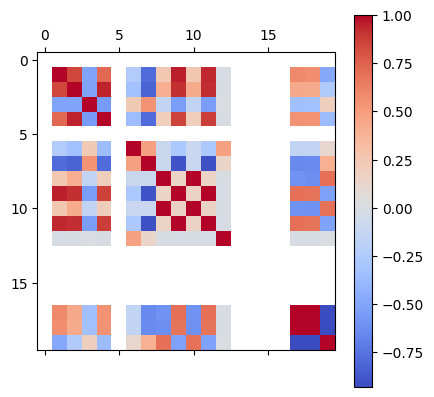

In [ ]:
plt.matshow(corr_matrix, cmap='coolwarm')
plt.colorbar()
plt.show()

In [ ]:
features = ["Temperature(degree_C)","Current(A)","Voltage(V)","Discharge_Capacity - Charge_Capacity(Ah)","Discharge_Energy - Charge_Energy(Wh)","dV/dt(V/s)"]


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Define Network Architecture (adjust based on experimentation)
model = keras.Sequential([
    Dense(units=32, activation='relu', input_shape=(X_train.shape[1],)),  # Hidden layer 1
    Dense(units=32, activation='relu'),                                   # Hidden layer 2
    Dense(units=1, activation='linear'),                                  # Output layer
])

model.compile(loss='mse', optimizer='adam', metrics=['mse'])
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test))

# Evaluate the Model
loss, mse = model.evaluate(X_test_scaled, y_test)
print(f"Test MSE: {mse}")

Epoch 1/50
471/471 [==============================] - 2s 2ms/step - loss: 1884.5840 - mse: 1884.5840 - val_loss: 94.5531 - val_mse: 94.5531
Epoch 2/50
471/471 [==============================] - 1s 3ms/step - loss: 45.6187 - mse: 45.6187 - val_loss: 22.3521 - val_mse: 22.3521
Epoch 3/50
471/471 [==============================] - 2s 4ms/step - loss: 17.6557 - mse: 17.6557 - val_loss: 14.7086 - val_mse: 14.7086
Epoch 4/50
471/471 [==============================] - 1s 3ms/step - loss: 11.1708 - mse: 11.1708 - val_loss: 9.0403 - val_mse: 9.0403
Epoch 5/50
471/471 [==============================] - 1s 2ms/step - loss: 7.3025 - mse: 7.3025 - val_loss: 5.6738 - val_mse: 5.6738
Epoch 6/50
471/471 [==============================] - 1s 2ms/step - loss: 5.0435 - mse: 5.0435 - val_loss: 4.3710 - val_mse: 4.3710
Epoch 7/50
471/471 [==============================] - 2s 4ms/step - loss: 3.5155 - mse: 3.5155 - val_loss: 2.7501 - val_mse: 2.7501
Epoch 8/50
471/471 [==============================] - 2s 4

118/118 [==============================] - 0s 1ms/step - loss: 353693368320.0000 - mse: 353693368320.0000
Test MSE: 353693368320.0


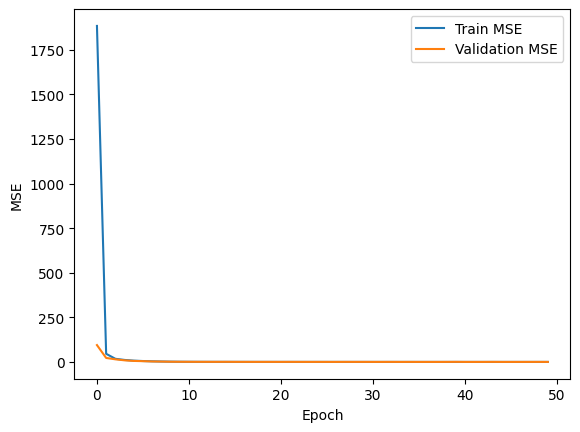

In [ ]:
loss, mse = model.evaluate(X_test, y_test)
print(f"Test MSE: {mse}")

# Plot learning curve using history object (optional)
import matplotlib.pyplot as plt

plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()
